# Pre-Setup

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [32]:
# !pip install --upgrade --no-cache-dir catboost
# !pip install --upgrade --no-cache-dir seaborn
# !pip install --upgrade --no-cache-dir featuretools
# !pip install --upgrade --no-cache-dir xgboost
# !pip install --upgrade --no-cache-dir lightgbm
# !pip install --upgrade --no-cache-dir tqdm
# !pip install --upgrade --no-cache-dir psutil
# !pip install --upgrade --no-cache-dir openpyxl
# !pip install --upgrade --no-cache-dir category_encoders

     |████████████████████████████████| 81kB 5.9MB/s 


In [126]:
import os
import re
import psutil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.notebook import tqdm
tqdm.pandas()

import featuretools as ft
from tabulate import tabulate
from collections import Counter

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold

import catboost as cgb
import xgboost as xgb
import lightgbm as lgb

from category_encoders import OrdinalEncoder

In [15]:
assert(sklearn.__version__ == '0.22.2.post1')
assert(cgb.__version__ == '0.24.4')
assert(xgb.__version__ == '1.3.3')
assert(lgb.__version__ == '3.1.1')

In [17]:
def plot_countplot(series_):
    """
    https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count
    :param series_:
    :return:
    """
    sns.set_style("whitegrid", {'axes.grid': False})
    headers = [series_.name, 'Count', 'Percentage']
    value_counts = series_.value_counts()
    value_counts_norm = series_.value_counts(normalize=True)
    table = [[
        v, value_counts[v], round(value_counts_norm[v], 3)
    ] for v in value_counts.index]
    print(tabulate(table, headers, tablefmt="psql"))
    sns.countplot(y=series_, orient='horizontal', order=value_counts.index)

def date_to_integer(dt_time):
    return 10_000 * dt_time.year + 100 * dt_time.month + dt_time.day

In [18]:
print(f"Using {psutil.cpu_count()} CPU Cores...")

Using 2 CPU Cores...


In [19]:
df_test_data = pd.read_pickle('https://turingequations.com/ltfs-finhack3-data/test_Data.pkl')

In [21]:
df_train_data = pd.read_pickle('https://turingequations.com/ltfs-finhack3-data/train_Data.pkl')
df_train_bureau = pd.read_pickle('https://turingequations.com/ltfs-finhack3-data/train_bureau.pkl')

df_test_data = pd.read_pickle('https://turingequations.com/ltfs-finhack3-data/test_Data.pkl')
df_test_bureau = pd.read_pickle('https://turingequations.com/ltfs-finhack3-data/test_bureau.pkl')

In [22]:
# (128655, 26) (560844, 25) (14745, 25) (64019, 25)
print(df_train_data.shape, df_train_bureau.shape, df_test_data.shape, df_test_bureau.shape)

(128655, 26) (560844, 25) (14745, 25) (64019, 25)


In [23]:
print("columns not in test data", [c for c in df_train_data.columns if c not in df_test_data.columns])
print("columns not in test bureau", [c for c in df_train_bureau.columns if c not in df_test_bureau.columns])

columns not in test data ['Top-up Month']
columns not in test bureau []


In [24]:
df_train_data['source'] = 'train'
df_train_bureau['source'] = 'train'
df_test_data['source'] = 'test'
df_test_bureau['source'] = 'test'

In [129]:
df_all_data = pd.concat([df_train_data, df_test_data], axis=0)
df_all_bureau = pd.concat([df_train_bureau, df_test_bureau], axis=0)

+-------------------+---------+--------------+
| Top-up Month      |   Count |   Percentage |
|-------------------+---------+--------------|
| No Top-up Service |  106677 |        0.829 |
| > 48 Months       |    8366 |        0.065 |
| 36-48 Months      |    3656 |        0.028 |
| 24-30 Months      |    3492 |        0.027 |
| 30-36 Months      |    3062 |        0.024 |
| 18-24 Months      |    2368 |        0.018 |
| 12-18 Months      |    1034 |        0.008 |
+-------------------+---------+--------------+


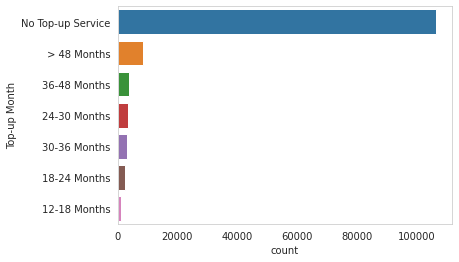

In [130]:
plot_countplot(df_all_data['Top-up Month'])

# Model

In [131]:
con_cols = [
    'Tenure',
    'AssetCost',
    'AmountFinance',
    'DisbursalAmount',
    'EMI',
    'LTV',
    'AGE',
    'MonthlyIncome',
]

cat_cols = [
    'Frequency',
    'InstlmentMode',
    'LoanStatus',
    'PaymentMode',
    'BranchID',
    'Area',
    'ManufacturerID',
    'SupplierID',
    'SEX',
    'City',
    'State',
    'ZiPCODE',
]

In [132]:
print("encoding target...")
target_encoder = LabelEncoder()
df_all_data.loc[df_all_data['source'] == 'train', 'Top-up Month'] = target_encoder.fit_transform(df_all_data[df_all_data['source'] == 'train']['Top-up Month'])

encoding target...


In [133]:
oe = OrdinalEncoder(return_df=False, handle_missing='return_nan', handle_unknown='error', drop_invariant=False)
df_all_data[cat_cols] = oe.fit_transform(df_all_data[cat_cols]) - 1

df_all_data[cat_cols] = df_all_data[cat_cols].fillna(-1)

ft = FunctionTransformer(lambda X: X.astype('int'))
df_all_data[cat_cols] = ft.fit_transform(df_all_data[cat_cols])

In [134]:
print("encoding date and categorical features...")
# for col in cat_cols:
#   oe = OrdinalEncoder(return_df=False, handle_missing='return_nan', handle_unknown='error', drop_invariant=False)
#   df_all_data[col] = oe.fit_transform(df_all_data[[col]]).flatten()
        
for col in ['DisbursalDate', 'MaturityDAte', 'AuthDate']:
  df_all_data[col] = df_all_data[col].map(date_to_integer)

encoding date and categorical features...


In [136]:
df_all_data[con_cols] = df_all_data[con_cols].replace([np.inf, -np.inf], np.nan)
df_all_data[cat_cols] = df_all_data[cat_cols].apply(lambda x: x.astype('category'))

## Modelling

In [137]:
train, test = df_all_data[df_all_data['source'] == 'train'], df_all_data[df_all_data['source'] == 'test']

In [138]:
config = dict()
config["lgb_params"] = {
    "num_classes": train['Top-up Month'].unique().size,
    "objective": "multiclass",
    "boosting_type": "gbdt",
    "metric" : "multi_logloss",
    "num_threads" : psutil.cpu_count()
}
config["xgb_params"] = {
    "num_class": train['Top-up Month'].unique().size,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "nthread" : psutil.cpu_count()
}
config["cgb_params"] = {
    "classes_count": train['Top-up Month'].unique().size,
    "objective": "MultiClass",
    "eval_metric": "TotalF1",
    "thread_count" : psutil.cpu_count()
}

In [139]:
def run_LGB(params, train, test, feature_names, n_folds=10, seed=0):
    """
    https://stackoverflow.com/questions/56303572/how-can-i-solve-this-unknown-label-type-error
    """
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')

    num_classes = np.unique(y).size
    preds = np.zeros((test.shape[0], params['num_classes']))

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val, reference=dtrain)

        bst = lgb.train(
            params=params,
            train_set=dtrain,
            valid_sets=[dtrain, dval],
            valid_names=['train', 'eval'],
            num_boost_round=30_000,
            verbose_eval=30,
            early_stopping_rounds=200
        )

        score_, iter_ = bst.best_score['eval']['multi_logloss'], bst.best_iteration
        test_preds = bst.predict(test[feature_names], num_iteration=iter_)
        preds += test_preds
    return preds / n_folds

In [140]:
def run_XGB(params, train, test, feature_names, n_folds = 10, seed = 0):
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['num_class']))
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = xgb.DMatrix(data=X_train, label=y_train, missing=np.nan)
        dval = xgb.DMatrix(data = X_val, label=y_val, missing=np.nan)

        bst = xgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 200,
                evals                 = [(dtrain, 'train'), (dval, 'eval')],
                verbose_eval          = 30
            )

        score_, iter_ = bst.best_score, bst.best_iteration
        test_preds = bst.predict(xgb.DMatrix(test[feature_names]))
        preds += test_preds
    return preds / n_folds

In [141]:
def run_CGB(params, train, test, feature_names, n_folds = 10, seed=0, cat_cols=None):
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['classes_count']))
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = cgb.Pool(data=X_train, label=y_train, cat_features=cat_cols)
        dval = cgb.Pool(data=X_val, label=y_val, cat_features=cat_cols)

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        params.update({
            'class_weights': {k: w for k, w in zip(np.unique(y_train), class_weights)}
        })
        
        bst = cgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 30,
                evals                 = [dtrain, dval],
                verbose_eval          = 30
            )

        score_, iter_ = bst.get_best_score(), bst.get_best_iteration()
        test_preds = bst.predict(cgb.Pool(test[feature_names], cat_features=cat_cols))
        preds += test_preds
    return preds / n_folds

In [ ]:
params = config["lgb_params"]
params = config["xgb_params"]
params = config["cgb_params"]
features = cat_cols + con_cols
preds_ = run_CGB(params, train, test, features, n_folds=10, seed=21, cat_cols=cat_cols)

Learning rate set to 0.032385
0:	learn: 0.3720572	test: 0.3731085	test1: 0.3664107	best: 0.3664107 (0)	total: 5.02s	remaining: 1d 17h 50m 18s
30:	learn: 0.3777748	test: 0.3792758	test1: 0.3713552	best: 0.3738929 (26)	total: 2m 21s	remaining: 1d 14h 4m 20s
60:	learn: 0.3895593	test: 0.3896550	test1: 0.3820458	best: 0.3828393 (51)	total: 4m 33s	remaining: 1d 13h 16m 50s
90:	learn: 0.3932838	test: 0.3931695	test1: 0.3845088	best: 0.3850102 (89)	total: 6m 46s	remaining: 1d 13h 7m 35s


In [ ]:
final_preds = target_encoder.inverse_transform(np.argmax(preds_, axis=1))

test_ids = test["ID"].values
df = pd.DataFrame({"ID" : test_ids, "Top-up Month" : final_preds})
df.to_csv(f"submissions/submission_{datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index = False)

In [ ]:
Counter(final_preds)

Counter({'No Top-up Service': 14705,
         '24-30 Months': 9,
         ' > 48 Months': 26,
         '18-24 Months': 3,
         '30-36 Months': 1,
         '36-48 Months': 1})

In [ ]:
Counter(final_preds)

Counter({'No Top-up Service': 14742, ' > 48 Months': 3})

In [ ]:
Counter(target_encoder.inverse_transform(y_test_pred))

Counter({'No Top-up Service': 3404,
         ' > 48 Months': 3677,
         '36-48 Months': 1887,
         '24-30 Months': 1364,
         '12-18 Months': 2082,
         '18-24 Months': 1162,
         '30-36 Months': 1169})